# Зависимости

In [ ]:
!pip -q install torch torchvision torchaudio transformers sentence-transformers scikit-learn datasets accelerate


In [ ]:
!pip install faiss-gpu
!pip install faiss-cpu


ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


# Импорт, чтение и сплит

In [ ]:
import json, os, random, math
from pathlib import Path
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DATA_PATH = Path("/content/lbd_train.jsonl")
rows = [json.loads(x) for x in open(DATA_PATH, encoding="utf-8")]
print("samples:", len(rows))
print("by skill:", Counter(r["skill"] for r in rows))


samples: 1327
by skill: Counter({'music.play': 184, 'weather.get': 177, 'reminder.add': 141, 'timer.start': 138, 'alarm.set': 134, 'time.now': 103, 'news.get': 103, 'music.stop': 97, 'math.calculate': 96, 'jokes.tell': 88, 'system.help': 66})


# Маскирование

In [ ]:
import re
from typing import Dict, Any, Tuple, List

# утилиты
def _store(slots: Dict[str, Any], key: str, value: str, placeholder: str, canon_key=None, canon_val=None):
    slots.setdefault(key, []).append(value.strip())
    if canon_key:
        slots.setdefault(canon_key, []).append(canon_val)
    return placeholder

def _canon(text: str) -> str:
    # мягкая канонизация для сравнения/логов
    t = text.strip()
    t = re.sub(r"\s+", " ", t)
    return t

def _merge_spans(spans: List[Tuple[int,int,str,str]]):
    spans = sorted(spans, key=lambda x:(x[0], x[1]))
    merged = []
    for s in spans:
        if not merged or s[0] >= merged[-1][1]:
            merged.append(s)
        else:
            # оставляем более длинный
            prev = merged[-1]
            if (s[1]-s[0]) > (prev[1]-prev[0]):
                merged[-1] = s
    return merged

#словари/регулы
TIME_WORDS = r"(сегодня|завтра|послезавтра|утром|днём|днем|вечером|ночью)"
MONTHS = r"(январ[ьяе]|феврал[ьяе]|март[ае]?|апрел[ьяе]|ма[ея]|июн[ьяе]|июл[ьяе]|август[ае]?|сентябр[ьяе]|октябр[ьяе]|ноябр[ьяе]|декабр[ьяе])"
UNITS = r"(секунд(?:а|ы)?|минут(?:а|ы)?|час(?:а|ов)?|дн(?:я|ей|ь))"
PREP = r"(?:в|во|на|из|по|к|у|с|со|под|над|около|между)"
CAP_WORD = r"[A-ZА-ЯЁ][\w\-]+"

# мини-база городов
CITY_LIST = ["москва","санкт-петербург","казань","берлин","лондон","париж","екатеринбург","новосибирск"]

SUFFIXES_FEM = ["а","ы","е","у","ой","ою"]
SUFFIXES_MASC_CONS = ["","а","у","ом","е"]
SUFFIXES_MASC_YJ = ["й","я","ю","ем","е"]
SUFFIXES_SOFT = ["ь","я","ю","ем","е"]
SUFFIXES_NEUT = ["о","а","у","ом","е"]

def _suffixes_for_last_token(tok: str):
    t = tok.lower()
    if t.endswith(("а","я")): return SUFFIXES_FEM
    if t.endswith("й"):       return SUFFIXES_MASC_YJ
    if t.endswith("ь"):       return SUFFIXES_SOFT
    if t.endswith(("о","е")): return SUFFIXES_NEUT
    return SUFFIXES_MASC_CONS

def _city_regex(city: str) -> re.Pattern:
    parts = re.split(r"[\s\-]+", city.strip().lower())
    head, last = parts[:-1], parts[-1]
    def stem(token: str): return re.escape(token[:-1]) if token[-1] in "аяоейь" else re.escape(token)
    suf = _suffixes_for_last_token(last)
    if last[-1] in "аяоейь":
        last_pat = stem(last) + "(?:" + "|".join(map(re.escape, suf)) + ")"
    else:
        opts = "|".join("" if s=="" else re.escape(s) for s in suf)
        last_pat = re.escape(last) + "(?:" + opts + ")"
    head_pat = (r"\b" + r"[-\s]".join(map(re.escape, head)) + r"[-\s]") if head else r"\b"
    return re.compile(head_pat + last_pat + r"\b", flags=re.I)

CITY_PATTERNS = [(c, _city_regex(c)) for c in CITY_LIST]

#основной пайплайн
def mask_entities(text: str) -> Tuple[str, Dict[str, Any]]:
    s: Dict[str, Any] = {}
    raw = text
    spans: List[Tuple[int,int,str,str]] = []

    # защищаем уже существующие
    protected = []
    for m in re.finditer(r"\{[a-z_]+\}", raw):
        protected.append((m.start(), m.end()))
    def _is_protected(a,b):
        return any(not (b<=x or a>=y) for x,y in protected)

    # TIME
    for m in re.finditer(r"\b([01]?\d|2[0-3]):[0-5]\d\b", raw):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{time}", "time"))

    # DATE
    for m in re.finditer(r"\b([0-3]?\d\.[01]?\d\.\d{4}|[0-3]?\d\.[01]?\d\b)", raw):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{date}", "date"))
    for m in re.finditer(rf"\b([0-3]?\d)\s+{MONTHS}\b", raw, flags=re.I):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{date}", "date"))
    for m in re.finditer(r"\b(в\s+понедельник|во\s+вторник|в\s+среду|в\s+четверг|в\s+пятницу|в\s+субботу|в\s+воскресенье)\b", raw, flags=re.I):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{date}", "date"))

    # TIME WORDS
    for m in re.finditer(TIME_WORDS, raw, flags=re.I):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{time}", "time"))

    # DURATION
    for m in re.finditer(rf"\b(через|на)\s+\d+\s+{UNITS}(?:\s+\d+\s+{UNITS})?\b", raw, flags=re.I):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{duration}", "duration"))
    for m in re.finditer(rf"\b\d+\s+{UNITS}\b", raw, flags=re.I):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{duration}", "duration"))

    #ЧИСЛА для math
    for m in re.finditer(r"(?<!\w)\d+(?:[.,]\d+)?(?!\w)", raw):
        a,b = m.start(), m.end()
        if not any(a<y and b>x for x,y,_,_ in spans):  # не пересекаться с duration/date/time
            if not _is_protected(a,b):
                spans.append((a,b,"{number}","number"))

    # MUSIC
    music_m = re.search(r"(включи|воспроизведи|сыграй|запусти|поставь)\s+(.+)", raw, flags=re.I)
    if music_m and not _is_protected(music_m.start(2), music_m.end(2)):
        spans.append((music_m.start(2), music_m.end(2), "{song}", "song"))

    # CITY
    for _, pat in CITY_PATTERNS:
        for m in pat.finditer(raw):
            if not _is_protected(m.start(), m.end()):
                spans.append((m.start(), m.end(), "{city}", "city"))

    # CITY (неизвестные)
    for m in re.finditer(rf"\b{PREP}\s+({CAP_WORD}(?:\s+{CAP_WORD}){{0,2}})\b", raw):
        a,b = m.start(1), m.end(1)
        if not any(a<y and b>x for x,y,_,_ in spans) and not _is_protected(a,b):
            spans.append((a,b,"{city}","city"))

    #Слияние пересечений
    spans = _merge_spans(spans)

    # Применение замен
    out = list(raw)
    extracted: Dict[str, Any] = {}
    for a,b,ph,slot in sorted(spans, key=lambda t:-t[0]):
        val = raw[a:b]
        _store(extracted, slot, val, ph, canon_key=f"{slot}_canon", canon_val=_canon(val))
        out[a:b] = list(ph)
    masked = "".join(out)
    masked = re.sub(r"\s+", " ", masked).strip()

    return masked, extracted


# Символьный токенайзер

In [ ]:
# строим символьный вокаб
SPECIALS = ["<pad>", "<unk>", "<bos>", "<eos>"]
charset = set()
for r in rows:
    charset.update(list(r["text"]))
itos = SPECIALS + sorted(charset)
stoi = {ch:i for i,ch in enumerate(itos)}
PAD, UNK, BOS, EOS = 0, 1, 2, 3

def encode_text(text, max_len=128):
    ids = [BOS] + [stoi.get(ch, UNK) for ch in text][:max_len-2] + [EOS]
    if len(ids) < max_len:
        ids = ids + [PAD]*(max_len-len(ids))
    return np.array(ids, dtype=np.int64)

skills = sorted(list({r["skill"] for r in rows}))
label2id = {s:i for i,s in enumerate(skills)}
id2label = {i:s for s,i in label2id.items()}

class IntentDataset(Dataset):
    def __init__(self, samples, max_len=128):
        self.samples = samples
        self.max_len = max_len
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        r = self.samples[i]
        x = encode_text(r["text"], self.max_len)
        y = label2id[r["skill"]]
        return torch.tensor(x), torch.tensor(y)

# сплит на train/val
ratio = 0.85
n = len(rows)
n_train = int(n*ratio)
perm = list(range(n)); random.shuffle(perm)
train_rows = [rows[i] for i in perm[:n_train]]
val_rows   = [rows[i] for i in perm[n_train:]]

train_ds = IntentDataset(train_rows, max_len=128)
val_ds   = IntentDataset(val_rows,   max_len=128)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
val_dl   = DataLoader(val_ds, batch_size=128, shuffle=False)
len_vocab = len(itos)
num_labels = len(skills)

len_vocab, num_labels, skills[:5]


(82,
 11,
 ['alarm.set', 'jokes.tell', 'math.calculate', 'music.play', 'music.stop'])

# Модель

In [ ]:
class NLUEncoder(nn.Module):
    def __init__(self, vocab_size, num_labels, emb_dim=96, cnn_channels=128, lstm_hidden=128, proj_dim=128):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD)
        self.conv = nn.Conv1d(emb_dim, cnn_channels, kernel_size=5, padding=2)
        self.pool = nn.AdaptiveMaxPool1d(64)  # фиксируем длину признаков
        self.bi_lstm = nn.LSTM(input_size=cnn_channels, hidden_size=lstm_hidden,
                               num_layers=1, batch_first=True, bidirectional=True)
        self.proj = nn.Linear(2*lstm_hidden, proj_dim)   # эмбеддер
        self.cls  = nn.Linear(2*lstm_hidden, num_labels) # классификатор

    def forward(self, x):
        # x: [B, T]
        e = self.emb(x)                 # [B, T, E]
        e = e.transpose(1,2)            # [B, E, T]
        c = F.relu(self.conv(e))        # [B, C, T]
        c = self.pool(c)                # [B, C, P]
        c = c.transpose(1,2)            # [B, P, C]
        # BiLSTM
        out, _ = self.bi_lstm(c)        # [B, P, 2H]
        feat = out.mean(dim=1)          # mean-pool по времени
        logits = self.cls(feat)         # [B, num_labels]
        z = self.proj(feat)             # [B, proj_dim]
        z = F.normalize(z, dim=-1)      # нормируем для cosine
        return logits, z


# Supervised Contrastive Loss

In [ ]:
def supcon_loss(z, y, temperature=0.07):

    device = z.device
    B = z.size(0)
    sim = torch.matmul(z, z.t()) / temperature  # [B,B]
    mask_pos = (y.unsqueeze(1) == y.unsqueeze(0)).to(device)  # [B,B]
    mask_self = torch.eye(B, dtype=torch.bool, device=device)
    mask_pos = mask_pos & (~mask_self)

    # лог-сумма по всем j != i
    logsumexp_all = torch.logsumexp(sim - 1e9*mask_self.float(), dim=1)  # [B]
    # сумма по позитивам
    sim_pos = sim.masked_fill(~mask_pos, -1e9)
    logsumexp_pos = torch.logsumexp(sim_pos, dim=1)  # [B]

    # средний по тем, у кого есть позитивы
    has_pos = mask_pos.any(dim=1)
    loss = -(logsumexp_pos[has_pos] - logsumexp_all[has_pos]).mean()
    if torch.isnan(loss):  # когда класс одиночный в батче
        return torch.tensor(0.0, device=device)
    return loss


# Обучение с нуля

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NLUEncoder(vocab_size=len_vocab, num_labels=num_labels).to(device)

optim = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
ce_loss = nn.CrossEntropyLoss()
LAMBDA = 0.2   # вес контрастивной части

def evaluate():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits, _ = model(xb)
            pred = logits.argmax(dim=1)
            correct += int((pred==yb).sum().item())
            total += yb.numel()
    return correct/total if total else 0.0

best_acc = 0.0
EPOCHS = 8
for ep in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits, z = model(xb)
        loss = ce_loss(logits, yb) + LAMBDA * supcon_loss(z, yb)
        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()
    acc = evaluate()
    print(f"epoch {ep}: val_acc={acc:.3f}")
    if acc > best_acc:
        best_acc = acc
        os.makedirs("models/char_cnn_bilstm", exist_ok=True)
        torch.save({"state_dict": model.state_dict(),
                    "itos": itos, "stoi": stoi,
                    "skills": skills}, "models/char_cnn_bilstm/model.pt")
print("best_acc:", best_acc)


epoch 1: val_acc=0.150
epoch 2: val_acc=0.255
epoch 3: val_acc=0.430
epoch 4: val_acc=0.545
epoch 5: val_acc=0.675
epoch 6: val_acc=0.800
epoch 7: val_acc=0.875
epoch 8: val_acc=0.895
best_acc: 0.895


# Инференс

In [ ]:
ckpt = torch.load("models/char_cnn_bilstm/model.pt", map_location=device)
model.load_state_dict(ckpt["state_dict"])
itos = ckpt["itos"]; stoi = {c:i for i,c in enumerate(itos)}
skills = ckpt["skills"]; label2id = {s:i for i,s in enumerate(skills)}
id2label = {i:s for s,i in label2id.items()}
model.eval()

def encode_for_model(text, max_len=128):
    ids = [BOS] + [stoi.get(ch, UNK) for ch in text][:max_len-2] + [EOS]
    ids = ids + [PAD]*max(0, max_len-len(ids))
    return torch.tensor([ids], dtype=torch.long, device=device)

@torch.no_grad()
def clf_prob_ours(masked_text: str):
    xb = encode_for_model(masked_text)
    logits, z = model(xb)
    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()
    k = int(probs.argmax())
    return float(probs[k]), id2label[k], z[0].cpu().numpy()


# FAISS

In [ ]:
import faiss

LBD = rows
lbd_texts = [r["text"] for r in LBD]
lbd_labels = [r["skill"] for r in LBD]

def embed_many(texts, batch=256):
    vecs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch):
            chunk = texts[i:i+batch]
            X = torch.stack([encode_for_model(t)[0] for t in chunk]).to(device)
            _, z = model(X)
            vecs.append(z.cpu().numpy())
    return np.vstack(vecs).astype("float32")

lbd_emb = embed_many(lbd_texts)
index = faiss.IndexFlatIP(lbd_emb.shape[1])
index.add(lbd_emb)
print("FAISS vectors:", index.ntotal)


FAISS vectors: 1327


# rank_skill

In [ ]:
RANK_COEFF = dict(alpha=0.55, beta=0.35, gamma=0.10)
THRESHOLD = 0.45
SKILL_BASE_WEIGHT = {s:0.5 for s in skills}

def rank_skill(q: str, context=None):
    # функция маскирования:
    masked, slots = mask_entities(q)

    # классификатор
    proba, cls_top, q_vec = clf_prob_ours(masked)

    # топ-K по FAISS
    D, I = index.search(q_vec[None, :].astype("float32"), k=min(5, len(LBD)))
    sims, idxs = D[0], I[0]

    # ранжирование
    best = None
    for sim, j in zip(sims, idxs):
        cand_skill = lbd_labels[j]
        score = (RANK_COEFF["alpha"] * float(sim)
                 + RANK_COEFF["beta"]  * (proba if cls_top==cand_skill else (1.0-proba))
                 + RANK_COEFF["gamma"] * SKILL_BASE_WEIGHT.get(cand_skill, 0.4))
        item = dict(skill=cand_skill, score=score, example=lbd_texts[j])
        if (best is None) or (item["score"]>best["score"]):
            best = item

    if not best or best["score"] < THRESHOLD:
        best = dict(skill="system.help", score=best["score"] if best else 0.0, example=None)

    return {
        "query": q,
        "masked": masked,
        "skill": best["skill"],
        "confidence": round(float(best["score"]),3),
        "slots": slots,
        "matched_example": best["example"],
        "clf_top": cls_top
    }


# Графики

Точность (классификатор): 0.826


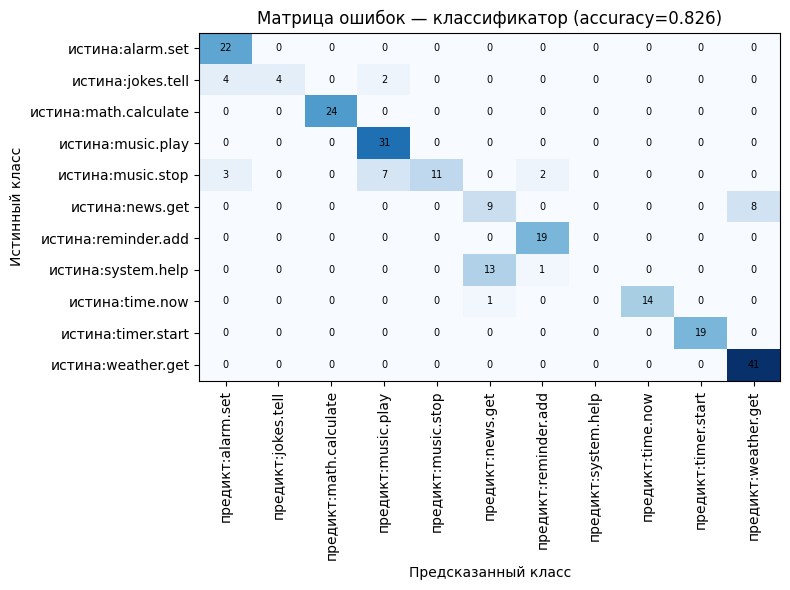

/tmp/ipython-input-2014331471.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["skill"], rotation=70)


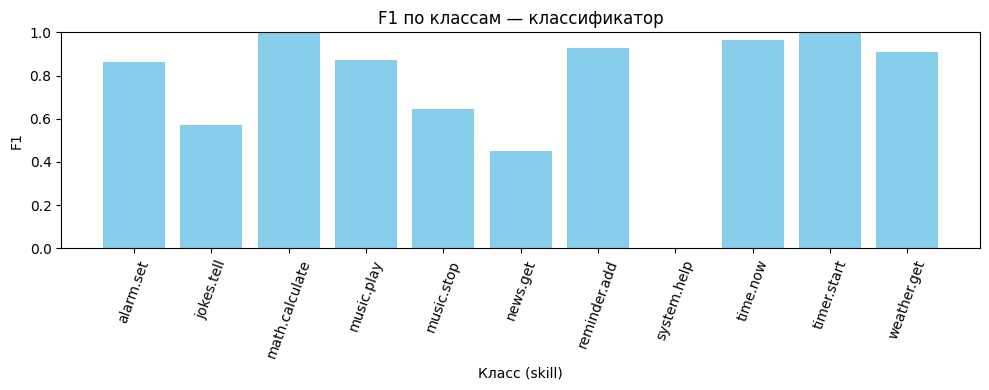

,skill,precision,recall,f1,support
0,alarm.set,0.758621,1.000000,0.862745,22
1,jokes.tell,1.000000,0.400000,0.571429,10
2,math.calculate,1.000000,1.000000,1.000000,24
3,music.play,0.775000,1.000000,0.873239,31
4,music.stop,1.000000,0.478261,0.647059,23
5,news.get,0.391304,0.529412,0.450000,17
6,reminder.add,0.863636,1.000000,0.926829,19
7,system.help,0.000000,0.000000,0.000000,14
8,time.now,1.000000,0.933333,0.965517,15
9,timer.start,1.000000,1.000000,1.000000,19


Точность (rank_skill): 0.945


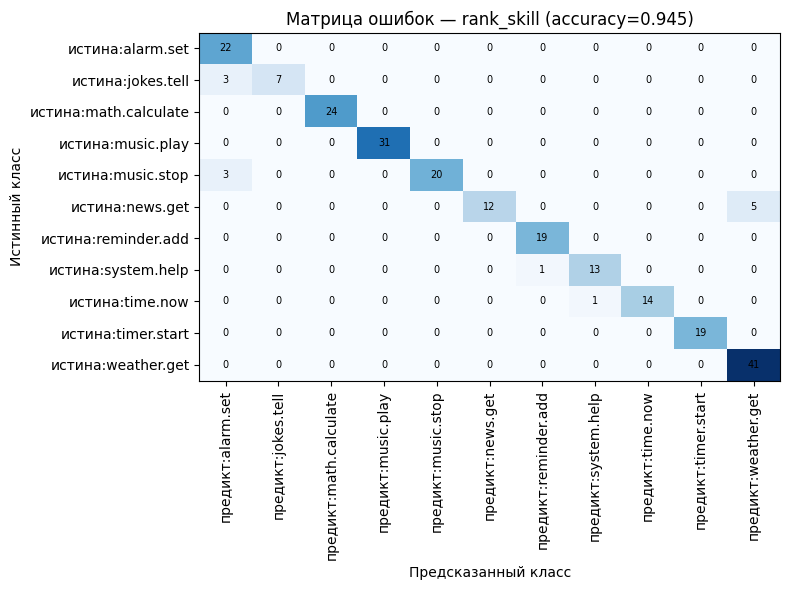

/tmp/ipython-input-2014331471.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["skill"], rotation=70)


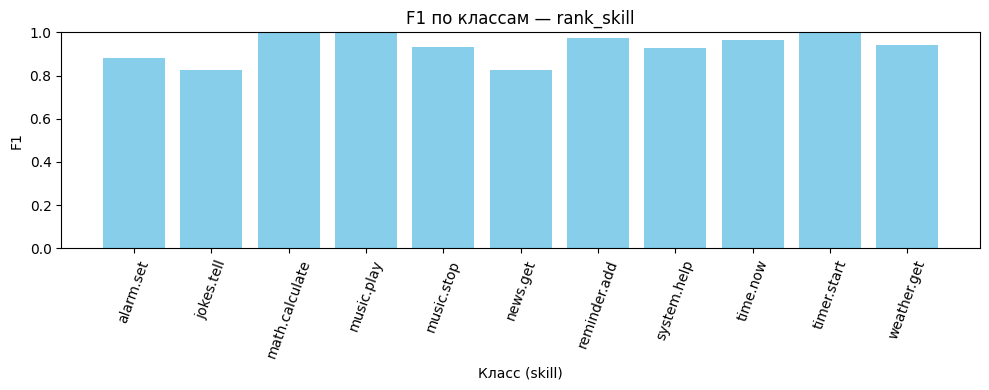

,skill,precision,recall,f1,support
0,alarm.set,0.785714,1.000000,0.880000,22
1,jokes.tell,1.000000,0.700000,0.823529,10
2,math.calculate,1.000000,1.000000,1.000000,24
3,music.play,1.000000,1.000000,1.000000,31
4,music.stop,1.000000,0.869565,0.930233,23
5,news.get,1.000000,0.705882,0.827586,17
6,reminder.add,0.950000,1.000000,0.974359,19
7,system.help,0.928571,0.928571,0.928571,14
8,time.now,1.000000,0.933333,0.965517,15
9,timer.start,1.000000,1.000000,1.000000,19


In [ ]:
#оценка точности
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from IPython.display import display

# классы
skills_set = set(r["skill"] for r in dev_rows)
if 'skills' in globals():
    skills_set |= set(skills)
labels = sorted(skills_set)

def per_class_df(y_true, y_pred, labels):
    p,r,f1,supp = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
    return pd.DataFrame({"skill":labels, "precision":p, "recall":r, "f1":f1, "support":supp})

def plot_confusion(cm_df, title_ru):
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    ax.imshow(cm_df.values, aspect='auto', cmap='Blues')
    ax.set_xticks(np.arange(cm_df.shape[1])); ax.set_yticks(np.arange(cm_df.shape[0]))
    ax.set_xticklabels(cm_df.columns, rotation=90); ax.set_yticklabels(cm_df.index)
    ax.set_xlabel("Предсказанный класс"); ax.set_ylabel("Истинный класс")
    ax.set_title(title_ru)
    for i in range(cm_df.shape[0]):
        for j in range(cm_df.shape[1]):
            ax.text(j, i, str(cm_df.iat[i,j]), ha='center', va='center', fontsize=7)
    fig.tight_layout()
    plt.show()

def plot_bar_f1(df_metrics, title_ru):
    fig = plt.figure(figsize=(10,4))
    ax = plt.gca()
    ax.bar(df_metrics["skill"], df_metrics["f1"], color="skyblue")
    ax.set_ylim(0,1)
    ax.set_xlabel("Класс (skill)"); ax.set_ylabel("F1")
    ax.set_title(title_ru)
    ax.set_xticklabels(df_metrics["skill"], rotation=70)
    fig.tight_layout()
    plt.show()

# Классификатор
y_true_c, y_pred_c = [], []
for r in dev_rows:
    masked, _ = mask_entities(r["text"])
    proba, pred_label, _ = clf_prob_ours(masked)
    y_true_c.append(r["skill"])
    y_pred_c.append(pred_label)

acc_c = accuracy_score(y_true_c, y_pred_c)
cm_c = confusion_matrix(y_true_c, y_pred_c, labels=labels)
df_cm_c = pd.DataFrame(cm_c, index=[f"истина:{c}" for c in labels], columns=[f"предикт:{c}" for c in labels])
df_metrics_c = per_class_df(y_true_c, y_pred_c, labels)

print(f"Точность (классификатор): {acc_c:.3f}")
plot_confusion(df_cm_c, f"Матрица ошибок — классификатор (accuracy={acc_c:.3f})")
plot_bar_f1(df_metrics_c, "F1 по классам — классификатор")
display(df_metrics_c)

# RankSkill
y_true_r, y_pred_r = [], []
for r in dev_rows:
    got = rank_skill(r["text"])
    y_true_r.append(r["skill"])
    y_pred_r.append(got["skill"])

acc_r = accuracy_score(y_true_r, y_pred_r)
cm_r = confusion_matrix(y_true_r, y_pred_r, labels=labels)
df_cm_r = pd.DataFrame(cm_r, index=[f"истина:{c}" for c in labels], columns=[f"предикт:{c}" for c in labels])
df_metrics_r = per_class_df(y_true_r, y_pred_r, labels)

print(f"Точность (rank_skill): {acc_r:.3f}")
plot_confusion(df_cm_r, f"Матрица ошибок — rank_skill (accuracy={acc_r:.3f})")
plot_bar_f1(df_metrics_r, "F1 по классам — rank_skill")
display(df_metrics_r)

# Тест

In [ ]:
def ask(q: str):
    res = rank_skill(q)
    print("Query:", q)
    print("Masked:", res["masked"])
    print("Skill:", res["skill"], f"(conf={res['confidence']})")
    print("Example:", res["matched_example"])
    print("Slots:", res["slots"])
    return res

while True:
    q = input(">>> ").strip()
    if q.lower() in {"q", "quit", "exit"}:
        break
    ask(q)


>>> посчитай 2+2
Query: посчитай 2+2
Masked: посчитай {number}+{number}
Skill: math.calculate (conf=0.859)
Example: эй разность {number} и {number} пж?
Slots: {'number': ['2', '2'], 'number_canon': ['2', '2']}


KeyboardInterrupt: Interrupted by user